In [1]:
# Setup inicial (mais geral)

#imports
import numpy as np
import pandas as pd

#Configuração para usar a base de dados de modo
#eficiente no google colab  --> comentar quando for rodar

from google.colab import drive

drive.mount('/content/drive')

PROJECT_PATH = '/content/drive/MyDrive/Competicao_DS_Arquivos'

!unzip $PROJECT_PATH/ieee-fraud-detection.zip

Mounted at /content/drive
Archive:  /content/drive/MyDrive/Competicao_DS_Arquivos/ieee-fraud-detection.zip
  inflating: sample_submission.csv   
  inflating: test_identity.csv       
  inflating: test_transaction.csv    
  inflating: train_identity.csv      
  inflating: train_transaction.csv   


Vamos inicialmente pegar os dados dos arquivos...

In [2]:
train_transaction = pd.read_csv("train_transaction.csv")
train_identity = pd.read_csv("train_identity.csv")

train_transaction = train_transaction.set_index("TransactionID")
train_identity = train_identity.set_index("TransactionID")

Apesar da utilização do google collab, limitações na quantidade de RAM disponível, além de tempos de runtime excessivo criou a necessidade de separação em um arquivo de teste/experimentos (este) e um para o real treinamento do modelo, pipeline, etc.

Além disso, mesmo neste segundo arquivo do collab, viu-se que a quantidade de RAM requerida era demais. Procurou-se reduzir a dimensionalidade das features vesta da competição (as mais numerosas, e provavelmente mais uteis por sua descrição), porém pela impossibilidade de descobrir sobre o que se tratavam dificultou a sua utilização (em agrupamentos e redução de dimensionalidade local), a dimensão de dimensionalidade global (entre todas as features vesta) era imprática do ponto de vista de uso de memória, além do fato de que tem-se a necessidade do tratamento de valores nulos, etc, o que é dificultado pela obscuridade das variáveis.

Dadas estas condições, foram descartadas todas estas variáveis, tendo em mente que provavelmente continham as mais úteis informações, além do fato de que, apesar de tudo, dado tempo e recursos suficientes, as análises/processamento destes dados seguiriam um padrão similar ao utilizado para as outras features.

In [3]:
train_transaction.drop([c for c in train_transaction.columns if c.startswith('V')], axis = 1,inplace = True)

In [4]:
#Resumo da natureza/tipos das variáveis restantes
for col, values in train_transaction.iteritems():
    num_uniques = values.nunique()
    print ('{name}: {num_unique}'.format(name=col, num_unique=num_uniques))
    print (values.unique() if num_uniques < 20 else values.mode())
    print ('\n')

for col, values in train_identity.iteritems():
    num_uniques = values.nunique()
    print ('{name}: {num_unique}'.format(name=col, num_unique=num_uniques))
    print (values.unique() if num_uniques < 20 else values.mode())
    print ('\n')

isFraud: 2
[0 1]


TransactionDT: 573349
0    9474817
dtype: int64


TransactionAmt: 20902
0    59.0
dtype: float64


ProductCD: 5
['W' 'H' 'C' 'S' 'R']


card1: 13553
0    7919
dtype: int64


card2: 500
0    321.0
dtype: float64


card3: 114
0    150.0
dtype: float64


card4: 4
['discover' 'mastercard' 'visa' 'american express' nan]


card5: 119
0    226.0
dtype: float64


card6: 4
['credit' 'debit' nan 'debit or credit' 'charge card']


addr1: 332
0    299.0
dtype: float64


addr2: 74
0    87.0
dtype: float64


dist1: 2651
0    0.0
dtype: float64


dist2: 1751
0    7.0
dtype: float64


P_emaildomain: 59
0    gmail.com
dtype: object


R_emaildomain: 60
0    gmail.com
dtype: object


C1: 1657
0    1.0
dtype: float64


C2: 1216
0    1.0
dtype: float64


C3: 27
0    0.0
dtype: float64


C4: 1260
0    0.0
dtype: float64


C5: 319
0    0.0
dtype: float64


C6: 1328
0    1.0
dtype: float64


C7: 1103
0    0.0
dtype: float64


C8: 1253
0    0.0
dtype: float64


C9: 205
0    1.0
dtype: float6

Questão 1

a) Compare as métricas acurácia e AUC para essa base de dados simulando os
seguintes modelos:
* Modelo que classifica aleatoriamente (50% chance de dizer que é
fraude e 50% de dizer que não é);
* Modelo que classifica todos os casos como fraude;
* Modelo que classifica todos os casos como não fraude.

In [5]:
from sklearn.metrics import accuracy_score , roc_auc_score
from sklearn.model_selection import train_test_split

In [6]:
y = train_transaction['isFraud']
X_transaction = train_transaction.drop(['isFraud'],axis=1)
X_identity = train_identity

threshold  = np.quantile(X_transaction.TransactionDT,0.7)

In [7]:
X_train_transaction = X_transaction[X_transaction['TransactionDT'] < threshold]
X_val_transaction = X_transaction[X_transaction['TransactionDT'] >= threshold]

In [8]:
X_train_identity = X_identity.loc[X_identity.index.intersection(X_train_transaction.index)]
X_val_identity = X_identity.loc[X_identity.index.difference(X_train_transaction.index)]

In [9]:
y_train = y[y.index.intersection(X_train_transaction.index)]
y_val = y[y.index.difference(X_train_transaction.index)]

In [10]:
def classificador_aleatorio(X):
  return np.random.randint(2, size=(len(X)))

def classificador_desconfiado(X):
  return np.ones((len(X),), dtype=int)

def classificador_ingenuo(X):
  return np.zeros((len(X),), dtype=int)

In [11]:
y_pred_aleatorio = classificador_aleatorio(X_train_transaction)
y_pred_desconfiado = classificador_desconfiado(X_train_transaction)
y_pred_ingenuo = classificador_ingenuo(X_train_transaction) 

In [12]:
acc_aleatorio =   accuracy_score(y_train,y_pred_aleatorio)
acc_desconfiado = accuracy_score(y_train,y_pred_desconfiado)
acc_ingenuo =     accuracy_score(y_train,y_pred_ingenuo)

print("Accuracy score para: ")
print("Classificador aleatorio: {:.2f}".format(acc_aleatorio))
print("Classificador desconfiado: {:.2f}".format(acc_desconfiado))
print("Classificador ingenuo: {:.2f}".format(acc_ingenuo))

Accuracy score para: 
Classificador aleatorio: 0.50
Classificador desconfiado: 0.04
Classificador ingenuo: 0.96


In [13]:
auc_aleatorio = roc_auc_score(y_train,y_pred_aleatorio)
auc_desconfiado = roc_auc_score(y_train,y_pred_desconfiado)
auc_ingenuo = roc_auc_score(y_train,y_pred_ingenuo)

print("AUC score para: ")
print("Classificador aleatorio: {:.2f}".format(auc_aleatorio))
print("Classificador desconfiado: {:.2f}".format(auc_desconfiado))
print("Classificador ingenuo: {:.2f}".format(auc_ingenuo))

AUC score para: 
Classificador aleatorio: 0.50
Classificador desconfiado: 0.50
Classificador ingenuo: 0.50


b) Discuta os resultados.

Temos com isso então a constatação, como esperado, da maior adequação ao problema de classificação da métrica de AUC. Isso ocorre primariamente por conta do desbalanceamento de classes: enquanto que a métrica de acurácia mede a precisão global de adequação de uma previsão (y_pred) para com os valores reais (y_train) temos que pela simples natureza dos dados (desbalanceados) teremos uma maior pontuação majoritamente ditada por acertar mais casos em que a **não** temos fraude. Enquanto isso, a métrica de AUC leva em consideração as **classes** do problema, tomando cada uma delas como igual, assim, essencialmente, temos o mesmo 'peso' dado à acertar a previsão em **cada** uma das classes, ao invés do panorama global anterior.

Isso ocorre pelo fato da área embaixo da curva da Receiving Operating Curve (ROC) representar (de certa forma) o quão bom o modelo é em classificar as classes, dada uma variação na threshold de escolha entre uma classe e outra.

Por conta disso, é clara a distinção de que esta segunda métrica é mais adequada para problemas de classificação (binária ao menos), como fora capaz de prover a mesma pontuação para os três modelos que não geram informação preditiva alguma, na medida que a primeira métrica distingue entre os três, levando-nos possivelmente a fazer decisões ruins na seleção de features e modelos em produção.

Questão 2

a) Proponha 3 novas variáveis explicativas que façam sentido do ponto de vista
prático do problema;
* Pelo menos duas delas devem ser criadas usando as informações dos
arquivos sobre os clientes (arquivos com nome identity);

De acordo com o próprio host da competição, as informações contidas na parte relativa à identidade esta criptografada e indiretamente apenas exposta (por questões de segurança), com a seguinte descrição:



    Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital 
    signature (UA/browser/os/version, etc) associated with transactions.
    They're collected by Vesta’s fraud protection system and digital security partners.
    (The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

    Categorical Features:

    DeviceType
    DeviceInfo
    id_12 - id_38



Sendo assim, estas variáveis contém dados acerca da secção virtual que fora realizada a transação (IP, ISP, Proxy, OS, browser, versão, etc) o que nos dá **bastante** informação acerca de como detectar fraudes.

Com relação ao conjunto de dados de transaction_train, temos, de acordo com o host da competição:

    Transaction Table

    TransactionDT: timedelta from a given reference datetime (not an actual timestamp)

    TransactionAMT: transaction payment amount in USD

    ProductCD: product code, the product for each transaction
    
    card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
    
    addr: address
    
    dist: distance
    
    P_ and (R__) emaildomain: purchaser and recipient email domain

    C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
    
    D1-D15: timedelta, such as days between previous transaction, etc.
    
    M1-M9: match, such as names on card and address, etc.
    
    Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

    Categorical Features:
    
    ProductCD
    card1 - card6
    addr1, addr2
    P_emaildomain
    R_emaildomain
    M1 - M9

O que nos indica que esta secção contém informação acerca da transação em si, sendo esta portanto possivelmente valiosa no discernimento do problema.

Temos porém um pequeno problema:

In [14]:
#Primeiramente vamos analisar as colunas
print(X_train_identity.columns)
print("\n\n")
print(X_train_transaction.columns)

Index(['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08',
       'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24',
       'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
       'DeviceInfo'],
      dtype='object')



Index(['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2',
       'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2',
       'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6',
       'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3',
       'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14',
       'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'],
      dtype='object')


In [15]:
#como o identificador de transação (TransactionID) é a única feature compartilhada entre ambos
#datasets, se quisermos de alguma maneira unir informações das duas partes, temos de junta-los
#sobre este index em comum, assim, temos o seguinte dataframe:

X_train_unido = pd.merge(X_train_identity, X_train_transaction, left_index=True, right_index=True)
X_train_unido

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,...,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,...,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device,...,anonymous.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows,...,gmail.com,gmail.com,1.0,4.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,83.000000,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,M0,NaN,NaN,NaN,NaN,NaN
2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN,...,hotmail.com,hotmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,M0,NaN,NaN,NaN,NaN,NaN
2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS,...,aol.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,26.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3400307,-5.0,141486.0,0.0,0.0,31.0,-12.0,NaN,NaN,0.0,0.0,100.0,NotFound,64.0,-300.0,Found,Found,166.0,15.0,391.0,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android 6.0.1,samsung browser 6.4,32.0,2560x1440,match_status:2,T,F,T,F,mobile,SAMSUNG,...,anonymous.com,anonymous.com,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,109.791664,0.791666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3400314,-5.0,34575.0,0.0,0.0,1.0,-9.0,NaN,NaN,0.0,0.0,100.0,NotFound,64.0,NaN,Found,Found,225.0,15.0,176.0,595.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 64.0,NaN,NaN,NaN,F,F,T,F,desktop,NaN,...,hotmail.com,hotmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,136.791672,0.791666,0.0,NaN,0.0,0.0,465.0,0.0,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN
3400351,-5.0,99755.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,-360.0,New,NotFound,166.0,NaN,312.0,253.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Windows 7,chrome 65.0,24.0,1280x1024,match_status:2,T,F,T,T,desktop,Windows,...,hotmail.com,gmail.com,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0

In [16]:
#Entretanto, surge um problema: como pode-se ver logo abaixo, a quantidade de instancias que possuem informação
#acerca da identidade é menor do que as que possuem acerca da transação
X_train_identity.shape[0] , X_train_transaction.shape[0] , X_train_unido.shape[0]

#Ainda assim, todas as instancias que possuem informação da identidade possuem TAMBÉM 
#acerca da transação. 

#Sendo assim, qualquer estratégia que necessite da totalidade dos dados (em ambos datasets)
#estaria incompleto (pois apenas funcionaria para parte das instancias).

(109911, 413378, 109911)

A partir desta observação formula-se a seguinte estratégia: 

Como as informações contidas no dataset de identidade é possivelmente muito útil para simplesmente descartar, temos de utiliza-la. Porém o modelo final não deve depender desta característica.

Tendo isso em mente, inicialmente pensou-se na implementação de um modelo de ensemble em que o valor final previsto é passado por um modelo que analisa as respostas de outros dois modelos.

Um dos modelos receberia apenas os dados de transaction e o outro de identity (se uma instância não possuir equivalente em ambos datasets, temos que a resposta final será dada pela resposta do modelo de transaction apenas).

Por limitações práticas (de testes de pipelines) e teóricas (provavelmente, e como testado uma hora, o conjunto de identity não possui instâncias nem dados o suficiente para a criação de um classificador robusto, e a classe prevalente era sempre prevista) essa ideia não foi seguida, e optou-se por uma simples ligação entre os datasets, com valores nulos atribuidos para os campos de identity que não existiam originalmente.

Sendo assim, temos de lidar inicialmente com os valores nulos, em uma análise inicial percebe-se que ambos os lados possuem **bastante** informação em falta.

In [17]:
#Vamos então verificar com relação a valores nulos

#apenas 53% dos dados de train_identity tem menos de 20% de valores nulos
print((100* X_train_identity.isna().sum() / len(X_train_identity) < 20).sum() / X_train_identity.shape[1])

print("\n")

#apenas 46% dos dados de train_identity tem menos de 20% de valores nulos
print((100* X_train_transaction.isna().sum() / len(X_train_transaction) < 20).sum() / X_train_transaction.shape[1])

0.525


0.5471698113207547


Separemos então caso a caso, começando pelo tratamento para identity.

In [18]:
#Vamos então fazer o tratamento caso a caso dos valores nulos

#Inicialmente, com relação à identidade, temos as seguintes colunas
print(X_train_identity.columns)

Index(['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08',
       'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24',
       'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
       'DeviceInfo'],
      dtype='object')


De acordo com a descrição dos dados, todas estas features são categóricas.

Como podem ser distinguidos dois grupos (id e Device) vamos trata-los separadamente

In [19]:
#Inicialmente para Device

#DeviceInfo possui cerca de 17% de nulos
print(X_train_identity.DeviceInfo.isna().sum() / len(X_train_identity))

#DeviceType possui cerca de 2% de nulos
print(X_train_identity.DeviceType.isna().sum() / len(X_train_identity))

0.16876381799819853
0.022873051832846575


In [20]:
#Vamos ver quais são os valores presentes em cada coluna
print(X_train_identity.DeviceInfo.nunique(),"\n")
X_train_identity.DeviceInfo

1546 



TransactionID
2987004         SAMSUNG SM-G892A Build/NRD90M
2987008                            iOS Device
2987010                               Windows
2987011                                   NaN
2987016                                 MacOS
                          ...                
3400307                               SAMSUNG
3400314                                   NaN
3400351                               Windows
3400353                                   NaN
3400363    HUAWEI VNS-L23 Build/HUAWEIVNS-L23
Name: DeviceInfo, Length: 109911, dtype: object

In [21]:
#Vamos ver quais são os valores presentes em cada coluna
print(X_train_identity.DeviceType.nunique(),"\n")
X_train_identity.DeviceType

2 



TransactionID
2987004     mobile
2987008     mobile
2987010    desktop
2987011    desktop
2987016    desktop
            ...   
3400307     mobile
3400314    desktop
3400351    desktop
3400353     mobile
3400363     mobile
Name: DeviceType, Length: 109911, dtype: object

Ao que pode-se ver temos uma distinção qualitativa imensa: por um lado, DeviceInfo é altamente diverso, com mais de 1000 tipos distintos, enquanto que DeviceType é apenas binário. 

Escolhe-se assim então uma binarização da variável DeviceType, visto que é possivelmente valiosa (dado que possivelmente fraudes de um certo tipo podem ser feitas mais facilmente em um desktop do que um celular ou vice-versa).

Enquanto isso, embora possa existir alguma correlação real entre o tipo do aparelho e a fraude, é esperado que seja mínimo, de forma que é mais provável que esta feature seja irrelevante (pois, por exemplo, dado que a **grande** maioria dos desktops utiliza-se de um sistema windows, a variável desktop e windows apresentariam praticamente a mesma informação) ou até mesmo prejudicial (pode ser que nesta época um modelo específico esteja em alta, o que pode aumentar as chances de ser associado como fraude). Sendo assim, esta coluna será descartada.

Quanto aos valores inexistentes, como estamos tratando de valores que serão contínuos futuramente (por conta da binarização da coluna deviceType) uma opção seria a substituição de 0,5 para valores nulos, ou então simplesmente a média (para invocar uma maior probabilidade de ser de algum tipo). Ambos serão tratados no pipeline final.

In [22]:
#apenas como teste, ambas propostas são próximas na prática
X_train_identity.DeviceType.map({'mobile': 0, 'desktop': 1}).mean()

0.6141977895099491

In [23]:
X_train_identity.DeviceType = X_train_identity.DeviceType.map({'mobile': 0, 'desktop': 1})

In [24]:
X_train_identity.drop(['DeviceInfo'],axis=1,inplace = True)

In [25]:
X_train_identity.DeviceType.fillna(-1,inplace=True)

Agora para as variáveis de id. De acordo com a descrição da competição, estas variáveis possuem imbutidas informações acerca da conexão, SO, ISP, Proxy, etc, o que pode ser **muito** útil na identificação de fraudes.

Uma feature **mista** que pode ser útil é a união da informação acerca da localização que um cliente realizou a sua operação, a informação de rede relativa a localização, e a quantidade de endereços registradas em nome do cliente.

Para ilustrar: imagine que um cliente fez uma compra em um determinado local (addr1 e addr2, junto de dist e possivelmente outras features) porém o ISP e Proxy registrados são incompatíveis ou improváveis de serem encontrados nesta região. Isso pode implicar em um acesso remoto, ou minimamente em um outlier que vale a pena ser vigiado.

Por conta do alto numero de valores nulos, dist1 e dist2 nao podem ser usados com confiança nem estabilidade, porém uma análise indica que addr1 e addr2 possuem poucos nulos

De acordo com a descricao dos dados, estes valores provavalmente indicam codigos zip, o que embora 
seriam tecnicamente categoricos, zips proximos geralmente indicam regioes proximas

Para isto vamos utilizar a seguinte estratégias: as features de identidade que podem mais robustamente prever addr1 e addr2 serão aquelas que irão ser utilizadas como suporte para esta nova variável mista. 

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [27]:
sel1 = SelectFromModel(RandomForestClassifier(n_estimators = 200,max_depth=3))
sel2 = SelectFromModel(RandomForestClassifier(n_estimators = 200,max_depth=3))

adr1 =  X_train_unido[['addr1']].fillna(-1,axis=1) 
adr2 =  X_train_unido[['addr2']].fillna(-1,axis=1) 

num_cols = [c for c in X_train_identity.columns if X_train_identity[c].dtype != 'object' ]
teste_id = X_train_identity[num_cols].fillna(-1,axis=1)

sel1.fit(teste_id,adr1)
sel2.fit(teste_id,adr2)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_from_model.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_from_model.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


SelectFromModel(estimator=RandomForestClassifier(max_depth=3, n_estimators=200))

Vamos então ver as importâncias

b) Faça uma análise ilustrando a (possível) qualidade das variáveis propostas.

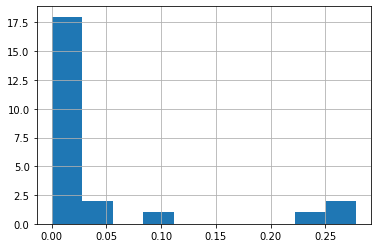

In [28]:
pd.Series(sel1.estimator_.feature_importances_.ravel()).hist()

In [29]:
sel1.get_feature_names_out()

array(['id_14', 'id_17', 'id_20', 'id_32'], dtype=object)

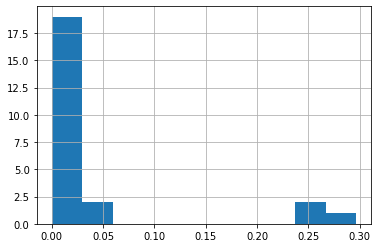

In [30]:
pd.Series(sel2.estimator_.feature_importances_.ravel()).hist()

In [31]:
sel1.get_feature_names_out()

array(['id_14', 'id_17', 'id_20', 'id_32'], dtype=object)

In [32]:
#A única feature que é capaz de realmente ser usada como previsora de qual é o endereço 
#seria id_02, sendo assim vamos nos utilizar de uma técnica de Outlier detection para verificar
#quais seriam os outliers, o que nos mostra discrepâncias entre o endereço atual e a informação 
#de rede registrada, e usar esta classificação (oulier ou não) como feature.

#Para isso um modelo de IsolationForest será usado

from sklearn.ensemble import IsolationForest

In [33]:
X_concat_custom_feat_1 = pd.concat([adr1['addr1'],adr2['addr2'],teste_id['id_02']],axis = 1)
clf_Outlier = IsolationForest(random_state=42).fit(X_concat_custom_feat_1)

In [34]:
#Temos entao uma média possivelmente muito alta de outliers, porém a informação
#de alerta em si de que é um outlier pode já ser o suficiente para melhorar a performance
#do modelo como um todo
(clf_Outlier.predict(X_concat_custom_feat_1) == -1).mean()

0.22272565985206214

In [35]:
X_train_custom_feat_1_df = pd.DataFrame(clf_Outlier.predict(X_concat_custom_feat_1),columns=['Outlier_tipo_1']).set_index(X_train_identity.index)

a) Proponha 3 novas variáveis explicativas que façam sentido do ponto de vista
prático do problema;

Uma outra (e última) ideia de "leak" de um conjunto de dados para o outro seria no seguinte cenário:

Imagine que uma grande quantidade de pagamentos é feita em sequência, com altas somas de dinheiro. O modelo que não possui acesso às features de identidade provavelmente preverá que é uma fraude, entretanto, como informações de identidade estão localizadas no modelo que tem acesso à identidade, pode ser que esta pessoa seja realmente muito rica, com nenhum erro de login e senha detectado (uma leitura nos comentários da competição informa que isso está presente em algum lugar nesta secção), o que pode nos levar a crer que são compras legítimas, feitas por alguém com bastante dinheiro.

In [36]:
#Vamos antes verificar na secção de transacoes se os valores correspondentes a algum tipo
#de contagem (da descricao: timedelta, such as days between previous transaction, etc. )

#verificacao de nulos
X_train_unido[['D%d'%(i+1) for i in range(15)]].isna().mean()

D1     0.000273
D2     0.807772
D3     0.824622
D4     0.569443
D5     0.784890
D6     0.565639
D7     0.776974
D8     0.488795
D9     0.488795
D10    0.549217
D11    1.000000
D12    0.613724
D13    0.599076
D14    0.591005
D15    0.549263
dtype: float64

O único valor que pode ser útil para a criação de uma feature seria D1 pois possui uma quantidade baixa de nulos, sendo portanto mais representativo da realidade.

Como escolha de definição de 'riqueza' toma-se a razão entre a quantidade de dinheiro gasto por intervalo de tempo. Assumindo que D1 realmente representa um intervalo de tempo válido entre transações, temos que o produto de TransactionAmt pelo inverso do tempo entre transações representa um 'gasto por tempo'.

Assim, um indivíduo é mais rico se gasta mais em menos tempo

Como feito para a variável anterior, temos de verificar quais das features em identity que possuem maior poder preditivo desta definição de riqueza. 

A feature final seria uma representação equivalente em identity da noção de riqueza apresentada e com isso, aplicamos uma detecção de outliers no conjunto completo.

Assim, nossas features novas seriam, em suma, se existe (-1) ou não (1) uma discrepância entre a definição de riqueza em identity e o gasto por tempo em transaction.

In [37]:
sel3 = SelectFromModel(RandomForestClassifier(n_estimators = 200,max_depth=3))

epsilon = 1e-3
freq_x_magnitude =  X_train_unido[['TransactionAmt']].fillna(-1,axis=1).to_numpy() / (X_train_unido[['D1']].fillna(-1,axis=1).to_numpy() + epsilon)

df_riq = pd.DataFrame(freq_x_magnitude,columns=['freq_x_magn']).set_index(X_train_identity.index).astype(int)

num_cols = [c for c in X_train_identity.columns if X_train_identity[c].dtype != 'object' ]
teste_id = X_train_identity[num_cols].fillna(-1,axis=1)

In [38]:
sel3.fit(teste_id,df_riq)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_from_model.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


SelectFromModel(estimator=RandomForestClassifier(max_depth=3, n_estimators=200))

b) Faça uma análise ilustrando a (possível) qualidade das variáveis propostas.

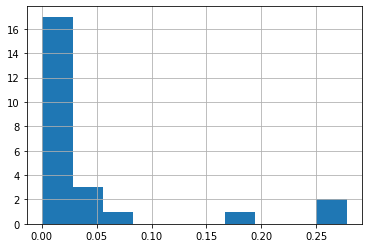

In [39]:
pd.Series(sel3.estimator_.feature_importances_.ravel()).hist()

In [40]:
sel3.get_feature_names_out()

array(['id_02', 'id_13', 'id_14', 'id_17', 'id_20', 'id_32'], dtype=object)

In [41]:
#novamente parece que temos que id_02 é a feature com maior poder preditivo de 'riqueza'
#isso pode ser pois a localizao de uma pessoa seria sim um indicador de riqueza, porém
#como o significado dos dados está mascarado fica complicado afirmar isso, e portanto
#nao devemos pular para concluir isso ainda
X_concat_custom_feat_2 = pd.concat([df_riq['freq_x_magn'],teste_id['id_02']],axis = 1)

clf_Outlier_2 = IsolationForest(random_state=42).fit(X_concat_custom_feat_2)

In [42]:
# a quantidade de outliers é similar, um bom sinal!
outliers_2 = clf_Outlier_2.predict(X_concat_custom_feat_2)
(outliers_2 == -1).mean()

0.17309459471754418

In [43]:
X_train_custom_feat_2_df = pd.DataFrame(clf_Outlier_2.predict(X_concat_custom_feat_2),columns=['Outlier_tipo_2']).set_index(X_train_identity.index)

Neste instante, como notou-se anteriormente, existem muitos valores nulos em id, por isso, para estas colunas, vamos adotar a seguinte estratégia:

* Se a coluna se referir a variaveis do tipo object **E** tivermos muitas labels/classes (>10) entao a coluna é descartada. Se tiver um número baixo (<=10) de labels/classes então utiliza-se um preenchimento numérico **RUDE** (labelEncoder).

* Se a coluna for numérica, os valores nulos são simplesmente marcados como -1.

Isso tudo ocorre pois, devido a alta quantidade de nulos, é muito fácil o modelo se enviesar pela baixa quantidade de amostras, portanto, efetivamente se 'suaviza-se' o efeito disso pela redução de dimensionalidade (por PCA) de modo que estas features em si (id na dimensão menor) são mais úteis.

In [44]:
from sklearn.preprocessing import LabelEncoder

In [45]:
id_cols= ['id_0%d'%(i+1) for i in range(9)] + ['id_%d'%(i+1) for i in range(9,38)]

transformers = {}

for c in id_cols:
  if X_train_identity[c].dtype == 'object':
    if X_train_identity[c].nunique() > 10:
      X_train_identity.drop(c,inplace= True,axis=1)
    else:
      le = LabelEncoder()
      X_train_identity[c].fillna("Unknown",inplace = True)
      le.fit(list(X_train_identity[c].astype(str).values))
      X_train_identity[c] = le.transform(list(X_train_identity[c].astype(str).values))
      transformers[c] = le
  else:
    X_train_identity[c].fillna(-1,inplace = True)

In [46]:
#Recuperam-se então todas as colunas id
id_train_num = X_train_identity[[c for c in X_train_identity.columns if c.startswith('id_')]]

In [47]:
#Aplica-se PCA, com 95% da variancia explicada nos eixos
from sklearn.decomposition import PCA

pca_id = PCA(n_components = 0.95)

pca_id_feat = pca_id.fit_transform(id_train_num)

In [48]:
#Aparentemente (de forma estranha, embora realmente muitos valores nulos existiam) só temos um eixo
pca_id.explained_variance_ratio_

array([0.99999581])

In [49]:
#Com uma escala muito alta
pca_id_feat

array([[-92468.94993981],
       [-64310.81890489],
       [ 28375.22294303],
       ...,
       [-63500.88516961],
       [148370.29675202],
       [-61837.72372661]])

In [50]:
from sklearn.preprocessing import MinMaxScaler

mM_id = MinMaxScaler()

pca_id_feat = mM_id.fit_transform(pca_id_feat)

In [51]:
#Converte-se
pca_id_feat_df = pd.DataFrame(pca_id_feat, columns=['id']).set_index(X_train_identity.index)

Sendo assim, as features finais desta categoria são...

In [52]:
feat_train_identity = pd.concat([pca_id_feat_df,X_train_custom_feat_1_df,X_train_custom_feat_2_df,X_train_identity[['DeviceType']]],axis=1)

In [53]:
feat_train_identity

,id,Outlier_tipo_1,Outlier_tipo_2,DeviceType
TransactionID,,,,
2987004,0.070816,1,1,0.0
2987008,0.098986,1,1,0.0
2987010,0.191710,1,1,1.0
2987011,0.221923,1,1,1.0
2987016,0.007464,-1,1,1.0
...,...,...,...,...
3400307,0.141544,1,1,0.0
3400314,0.034590,-1,1,1.0
3400351,0.099796,1,1,1.0


Para facilitar/possibilitar o uso desta forma de preprocessamento, poderia-se utilizar de column transformer, porém por diversas razões prefiriu-se testar a implementação de um transformer, por herança das classes base de sklearn.

In [54]:
from sklearn.base import BaseEstimator, TransformerMixin

#input X deve ter as colunas addr1, addr2, TransactionAmt e D1 concatenadas
class TransformerPreprocessamentoIdentity(BaseEstimator, TransformerMixin):

  transformers_fit = {}
  mM_pca_fit = ""
  Isolation_1 = ""
  Isolation_2 = ""
  pca_id_fit = ""
  cols_aplicar_fit = {}
  mM_id_fit =""

  def __init__(self):
    return 

  def fit(self, X, y = None):

    X = X.copy()

    #Ids
    id_cols = [c for c in X.columns if c.startswith('id_')]
    transformers = {}
    cols_aplicar = {}
    for c in id_cols:
      if X[c].dtype == 'object':
        if X[c].nunique() > 10:
          cols_aplicar[c] = "drop"
          X.drop(c,inplace= True,axis=1)
        else:
          cols_aplicar[c] = "label"
          le = LabelEncoder()
          X[c].fillna("Unknown",inplace = True)
          le.fit(list(X[c].astype(str).values))
          X[c] = le.transform(list(X[c].astype(str).values))
          transformers[c] = le
      else:
        X[c].fillna(-1,inplace = True)
        cols_aplicar[c] = "fill"

    #CustomFeature1
    adr1 =  X[['addr1_novo']].fillna(-1,axis=1) 
    adr2 =  X[['addr2_novo']].fillna(-1,axis=1)
    X_concat_custom_feat_1 = pd.concat([adr1['addr1_novo'],adr2['addr2_novo'],X['id_02']],axis = 1)
    clf_Outlier_1 = IsolationForest(random_state=42).fit(X_concat_custom_feat_1)
    
    #CustomFeature2
    epsilon = 1e-3
    freq_x_magnitude =  X[['TransactionAmt_novo']].fillna(-1,axis=1).to_numpy() / (X[['D1_novo']].fillna(-1,axis=1).to_numpy() + epsilon)
    df_riq = pd.DataFrame(freq_x_magnitude,columns=['freq_x_magn']).set_index(X.index).astype(int)
    X_concat_custom_feat_2 = pd.concat([df_riq['freq_x_magn'],X['id_02']],axis = 1)
    clf_Outlier_2 = IsolationForest(random_state=42).fit(X_concat_custom_feat_2)
    
    #Final
    id_cols = [c for c in X.columns if c.startswith('id_')]
    id_train_num = X[id_cols]
    pca_id = PCA(n_components = 0.95)
    pca_id_feat = pca_id.fit_transform(id_train_num)
    mM_id = MinMaxScaler()
    mM_id.fit(pca_id_feat)

    #Salvar valores na classe
    self.mM_pca_fit = mM_id
    self.transformers_fit = transformers
    self.Isolation_1 = clf_Outlier_1
    self.Isolation_2 = clf_Outlier_2
    self.mM_id_fit =  mM_id
    self.pca_id_fit = pca_id
    self.cols_aplicar_fit = cols_aplicar
    
    return self

  def transform(self, X, y = None):

    #DeviceInfo
    X.drop(["DeviceInfo"],inplace = True, axis = 1)

    #DeviceType
    X.DeviceType = X.DeviceType.map({'mobile': 0, 'desktop': 1})
    X.DeviceType.fillna(-1,inplace=True)

    #Ids
    id_cols = [c for c in X.columns if c.startswith('id_')]
    for c in id_cols:
      if self.cols_aplicar_fit[c] == 'drop':
        X.drop(c,inplace= True,axis=1)
      elif self.cols_aplicar_fit[c] == 'label':
        X[c].fillna("Unknown",inplace = True)
        X[c] = self.transformers_fit[c].transform(list(X[c].astype(str).values))
      else:
        X[c].fillna(-1,inplace = True)
    
    #CustomFeature1
    adr1 =  X[['addr1_novo']].fillna(-1,axis=1) 
    adr2 =  X[['addr2_novo']].fillna(-1,axis=1)
    X_concat_custom_feat_1 = pd.concat([adr1['addr1_novo'],adr2['addr2_novo'],X['id_02']],axis = 1)
    X_custom_feat_1_df = pd.DataFrame(self.Isolation_1.predict(X_concat_custom_feat_1),columns=['Outlier_tipo_1']).set_index(X.index)
    X.drop(['addr1_novo','addr2_novo'],axis =1, inplace = True)

    #CustomFeature2
    epsilon = 1e-3
    freq_x_magnitude =  X[['TransactionAmt_novo']].fillna(-1,axis=1).to_numpy() / (X[['D1_novo']].fillna(-1,axis=1).to_numpy() + epsilon)
    df_riq = pd.DataFrame(freq_x_magnitude,columns=['freq_x_magn']).set_index(X.index).astype(int)
    X_concat_custom_feat_2 = pd.concat([df_riq['freq_x_magn'],X['id_02']],axis = 1)
    X_custom_feat_2_df = pd.DataFrame(self.Isolation_2.predict(X_concat_custom_feat_2),columns=['Outlier_tipo_2']).set_index(X.index)
    X.drop(['TransactionAmt_novo','D1_novo'],axis =1, inplace = True)

    #Final
    id_cols = [c for c in X.columns if c.startswith('id_')]
    id_train_num = X[id_cols]
    pca_id_feat = self.pca_id_fit.transform(id_train_num)
    pca_id_feat = self.mM_id_fit.transform(pca_id_feat)
    pca_id_feat_df = pd.DataFrame(pca_id_feat, columns=['id']).set_index(X.index)
    feat_identity = pd.concat([pca_id_feat_df,X_custom_feat_1_df,X_custom_feat_2_df,X[['DeviceType']]],axis=1)

    return feat_identity

Para a próxima secção, por existirem algumas facilidades de interpretação dos dados, além de menos features do tipo string/object, implementa-se apenas o transformer, sem a redundância de demonstrar antes a transformação dos dados fora da classe.

Agora vamos para a feature nova remetente ao conjunto de transactions. Após analisar as colunas, nota-se uma ampla abundância de colunas numéricas, o que é desejável. Portanto, vamos analisar as do tipo object para investigar alguma forma interessante de criação de features:

In [55]:
features_strings = [c for c in X_train_transaction if X_train_transaction[c].dtype== 'object']
features_strings

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9']

Agora para a verificação de valores nulos e número de valores diferentes:

In [56]:
#Valores diferentes: Apenas dominios de email (como esperado) possuem uma variabilidade alta
for c in features_strings:
  print(c,' : ',X_train_transaction[c].nunique())

ProductCD  :  5
card4  :  4
card6  :  4
P_emaildomain  :  59
R_emaildomain  :  60
M1  :  2
M2  :  2
M3  :  2
M4  :  3
M5  :  2
M6  :  2
M7  :  2
M8  :  2
M9  :  2


In [57]:
#Valores nulos
for c in features_strings:
  print(c,' : ',X_train_transaction[c].isna().mean())

ProductCD  :  0.0
card4  :  0.0020054284456357137
card6  :  0.0019981711653740642
P_emaildomain  :  0.15553803056766446
R_emaildomain  :  0.7507341948531369
M1  :  0.5380426631315648
M2  :  0.5380426631315648
M3  :  0.5380426631315648
M4  :  0.48417429084276375
M5  :  0.6041564863151885
M6  :  0.31121878764714134
M7  :  0.6692059083937704
M8  :  0.6691962320200882
M9  :  0.6691962320200882


Pela alta quantidade de nulos nas features de tipo M, temos que o mais proveitoso seria uma redução de dimensionalidade por PCA em um conjunto de features codificadas por label encoder (sem muitas perdas por conta de termos poucos tipos diferentes).

Os endereços de email provavelmente são úteis apenas na medida em que representam algo relativo a probabilidade de serem encontrados, porém por fins de interpretabilidade opta-se pela representação da auto-informação do valor.

Como card4 e card6 estão inseridas em um contexto em que temos outros tipos de card, vale a pena levar em conta isso e apenas utilizar um label encoder junto de um preenchimento de valores faltantes.

ProductCD parece ser importante demais para realizar uma simples codificação de labels, e como temos uma situação simples (5 valores unicos apenas) vamos realizar uma codificação por OneHotEncoding.

Como para os emails realizou-se uma transformação mais elaborada, sem necessariamente utilizar técnicas mais simples, conta-se como uma forma de feature engineering, solicitada pela questão 2:

a) Proponha 3 novas variáveis explicativas que façam sentido do ponto de vista
prático do problema;

Realiza-se um pequeno teste para verificar a validade desta abordagem, verificando se a distribuição (de frequências de emails) realmente parece ser semelhante em ambos conjuntos.

b) Faça uma análise ilustrando a (possível) qualidade das variáveis propostas.

In [79]:
def RealizaTokenizacao(X):

  tokens_email_P = {}
  for name in X['P_emaildomain'].unique().tolist():
    tokens_email_P[name] = 0
  tokens_email_P['Unknown'] = 0

  tokens_email_R = {}
  for name in X['R_emaildomain'].unique().tolist():
    tokens_email_R[name] = 0
  tokens_email_R['Unknown'] = 0

  for line in X['P_emaildomain']:
    if line in tokens_email_P.keys():
      tokens_email_P[line]+=1
    else:
      tokens_email_P['Unknown']+=1

  for line in X['R_emaildomain']:
    if line in tokens_email_R.keys():
      tokens_email_R[line]+=1
    else:
      tokens_email_R['Unknown']+=1

  tam_P = len(X['P_emaildomain'])
  for key in tokens_email_P.keys():
      tokens_email_P[key] = tokens_email_P[key]/tam_P
  
  tam_R = len(X['R_emaildomain'])
  for key in tokens_email_R.keys():
      tokens_email_R[key] = tokens_email_R[key]/tam_R

  return tokens_email_P, tokens_email_R

In [80]:
P_train,R_train = RealizaTokenizacao(X_train_transaction)
P_val,R_val = RealizaTokenizacao(X_val_transaction)

In [81]:
erro_P = 0.0
for p in P_train.keys():
  if(p in P_val.keys()):
    erro_P+=(P_train[p] - P_val[p])**2

print( "Variancia P: %f"%( np.sqrt(erro_P/( len(P_train.keys()) - 1) ) ) )

Variancia P: 0.002537


In [82]:
erro_R = 0.0
for p in R_train.keys():
  if(p in R_val.keys()):
    erro_R += (R_train[p] - R_val[p])**2

print( "Variancia R: %f"%( np.sqrt(erro_R/( len(R_train.keys()) - 1) ) ) )

Variancia R: 0.007940


Como temos uma variância baixa, vale a pena provavelmente a utilização desta forma de processamento.

In [58]:
from sklearn.preprocessing import OneHotEncoder

In [83]:
class TransformerPreprocessamentoTransaction(BaseEstimator, TransformerMixin):

  encProdCD_fit = ""
  le_card4_fit = ""
  le_card6_fit = ""
  tokens_email_P_fit = ""
  tokens_email_R_fit = ""
  M_le_fit = ""
  pca_M_fit = ""
  
  def __init__(self):
    return 

  def fit(self, X, y = None):
    X = X.copy()

    #ProductCD
    encProdCD = OneHotEncoder(handle_unknown='ignore',sparse = False)
    X['ProductCD'].fillna("Unknown",inplace = True)
    encProdCD.fit(X[['ProductCD']])

    #card4 e card6
    le_card4 = LabelEncoder()
    le_card6 = LabelEncoder()
    X['card4'].fillna("Unknown",inplace = True)
    X['card6'].fillna("Unknown",inplace = True)
    le_card4.fit(list(X['card4'].astype(str).values))
    le_card6.fit(list(X['card6'].astype(str).values))

    #emails
    tokens_email_P = {}
    for name in X['P_emaildomain'].unique().tolist():
      tokens_email_P[name] = 0
    tokens_email_P['Unknown'] = 0

    tokens_email_R = {}
    for name in X['R_emaildomain'].unique().tolist():
      tokens_email_R[name] = 0
    tokens_email_R['Unknown'] = 0

    for line in X['P_emaildomain']:
      if line in tokens_email_P.keys():
        tokens_email_P[line]+=1
      else:
        tokens_email_P['Unknown']+=1

    for line in X['R_emaildomain']:
      if line in tokens_email_R.keys():
        tokens_email_R[line]+=1
      else:
        tokens_email_R['Unknown']+=1

    tam_P = len(X['P_emaildomain'])
    for key in tokens_email_P.keys():
      tokens_email_P[key] = tokens_email_P[key]/tam_P

    tam_R = len(X['R_emaildomain'])
    for key in tokens_email_R.keys():
      tokens_email_R[key] = tokens_email_R[key]/tam_R
    
    #Features M
    M_le = {}
    for i in range(9):      
      X['M%d'%(i+1)].fillna("Unknown",inplace = True)     
      le = LabelEncoder()     
      le.fit(list(X['M%d'%(i+1)].astype(str).values))
      X['M%d'%(i+1)] = le.transform(list(X['M%d'%(i+1)].astype(str).values))   
      M_le['M%d'%(i+1)] = le
    

    pca_M = PCA(n_components=0.95)
    pca_M.fit(X[['M%d'%(i+1) for i in range(9)]])

    #Salvar os parametros
    self.encProdCD_fit = encProdCD
    self.le_card4_fit = le_card4
    self.le_card6_fit = le_card6
    self.tokens_email_P_fit = tokens_email_P
    self.tokens_email_R_fit = tokens_email_R
    self.M_le_fit = M_le
    self.pca_M_fit = pca_M

    return self

  def transform(self, X, y = None):

    #Features numericas apenas recebem um valor que representa nulo
    non_obj_cols = [c for c in X.columns if X[c].dtype != 'object']
    X[non_obj_cols] = X[non_obj_cols].fillna(-1)

    #ProductCD
    X['ProductCD'].fillna("Unknown",inplace = True)
    X.join(pd.DataFrame(self.encProdCD_fit.transform(X[['ProductCD']])).set_index(X.index)) 
    X.drop(['ProductCD'],axis=1,inplace=True)

    #card4 e card6
    X['card4'].fillna("Unknown",inplace = True)
    X['card6'].fillna("Unknown",inplace = True)
    X['card4'] = self.le_card4_fit.transform(list(X['card4'].astype(str).values))
    X['card6'] = self.le_card6_fit.transform(list(X['card6'].astype(str).values))

    #emails
    X['P_emaildomain'] = X['P_emaildomain'].map(self.tokens_email_P_fit).apply(lambda p: -p*np.log2(p))
    X['R_emaildomain'] = X['R_emaildomain'].map(self.tokens_email_R_fit).apply(lambda p: -p*np.log2(p))

    #Features M
    for i in range(9):      
      X['M%d'%(i+1)].fillna("Unknown",inplace = True)        
      X['M%d'%(i+1)] = self.M_le_fit['M%d'%(i+1)].transform(list(X['M%d'%(i+1)].astype(str).values))
    
    X.join(pd.DataFrame(self.pca_M_fit.transform(X[['M%d'%(i+1) for i in range(9)]])).set_index(X.index))
    X.drop(['M%d'%(i+1) for i in range(9)],axis=1,inplace=True)

    return X
    

Para o teste da pipeline, no outro notebook, será utilizada a seguinte classe, que essencialmente cria uma espécie de 'wrapper' para os classificadores do sklearn.

In [84]:
class ClfSwitcher(BaseEstimator):

  def __init__(self,estimator = RandomForestClassifier(n_estimators=100,max_depth=3)):
      self.estimator = estimator
      return 

  def fit(self, X, y=None, **kwargs):
      self.estimator.fit(X, y)
      return self

  def predict(self, X, y=None):
      return self.estimator.predict(X)

  def predict_proba(self, X):
      return self.estimator.predict_proba(X)

  def score(self, X, y):
      return self.estimator.score(X, y)

Sendo que agora (com o drop das variáveis vesta) temos um número muito menor de colunas para trabalhar com, tornando o problema tratável do ponto de vista computacional.

In [85]:
X_train_transaction.shape , X_train_identity.shape

((413378, 53), (109911, 36))

Algumas ideias exploradas (nem todas usadas): 
* usar SelectPercentile para realmente eliminar variaveis
* usar MutualInformationScore para ponderar variaveis

Links e referências usadas para os testes/formulação:

* https://stackoverflow.com/questions/48507651/multiple-classification-models-in-a-scikit-pipeline-python

* https://stackoverflow.com/questions/34624978/is-there-easy-way-to-grid-search-without-cross-validation-in-python

* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mutual_info_score.html

* https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html

* https://towardsdatascience.com/select-features-for-machine-learning-model-with-mutual-information-534fe387d5c8

* https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html

* https://www.programcreek.com/python/example/93977/sklearn.feature_selection.SelectPercentile

* https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reindex.html